In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *

# Daily Bitcoin price

In [2]:
btc_data = pd.read_csv("BTC_price_2013-01-01_2024-12-15.csv",parse_dates=["Date"], index_col="Date")
btc_data = btc_data.iloc[::-1]
bitcoin_price = pd.DataFrame(btc_data["Price"])
bitcoin_price = bitcoin_price[bitcoin_price.index >= '2017-01-01']

In [3]:
bitcoin_price.head()

,Price
Date,
2017-01-01,995.4
2017-01-02,1017.0
2017-01-03,1033.3
2017-01-04,1135.4
2017-01-05,989.3


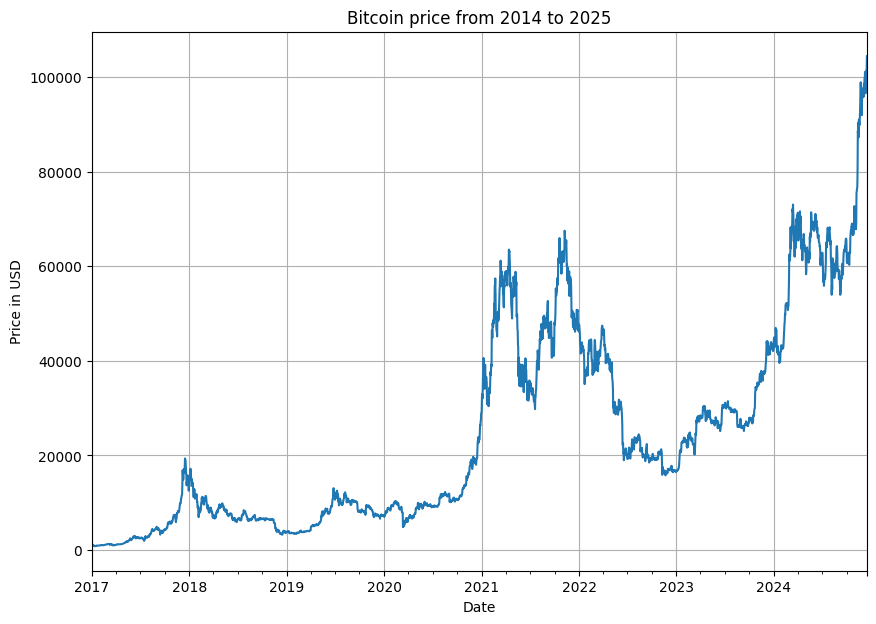

In [4]:
import matplotlib.pyplot as plt
bitcoin_price.plot(figsize=(10, 7))
plt.title("Bitcoin price from 2014 to 2025")
plt.ylabel("Price in USD")
plt.xlabel("Date")
plt.legend().remove()
plt.grid()
plt.show()

## Naive model

In [5]:
import csv
from datetime import datetime
timesteps = []
btc_price = []
with open("BTC_price_2013-01-01_2024-12-15.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",")
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
        btc_price.append(float(line[2]))
        
timesteps = bitcoin_price.index.to_numpy()
prices = bitcoin_price["Price"].to_numpy()

In [6]:
split_size = int(0.9 * len(prices)) 
X_test, y_test = timesteps[split_size:], prices[split_size:]
X_train, y_train = timesteps[:split_size], prices[:split_size]

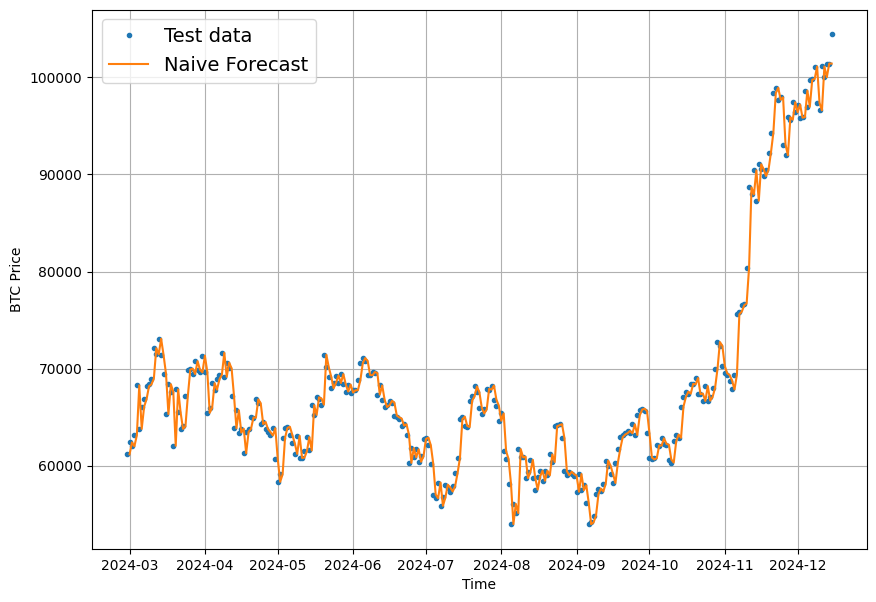

In [ ]:
naive_forecast = y_test[:-1]
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test, values=y_test, label="Test data",format=".")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

### Evaluate Naive model

In [12]:
results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
results

{'mae': np.float32(1386.9772),
 'mse': np.float32(3616419.0),
 'rmse': np.float32(1901.6885),
 'mape': np.float32(2.040159),
 'mase': np.float32(0.99960446)}

## Feedforward Neural Network

### Data Preparation 

In [45]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=30, horizon=7)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.1)

In [158]:
len(test_labels)

288

### Build and fit model

In [107]:
import tensorflow as tf
from tensorflow.keras import layers

fnn_model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(7) 
], name="fnn_model")

# Compile the model
fnn_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),)

# Fit the model
fnn_model.fit(x=train_windows, 
            y=train_labels,
            epochs=200,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[crteate_model_checkpoint(model_name=fnn_model.name)])

### Evaluate the model

In [108]:
fnn_model = tf.keras.models.load_model("models/fnn_model.keras")
fnn_model.evaluate(test_windows, test_labels)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2670.5940 


2642.76904296875

In [109]:
fnn_preds = make_preds(fnn_model, test_windows)
fnn_results = evaluate_preds(y_true=test_labels, y_pred=fnn_preds)
fnn_results

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


{'mae': np.float32(2642.769),
 'mse': np.float32(12584399.0),
 'rmse': np.float32(3547.4497),
 'mape': np.float32(3.9443398),
 'mase': np.float32(1.9079698)}

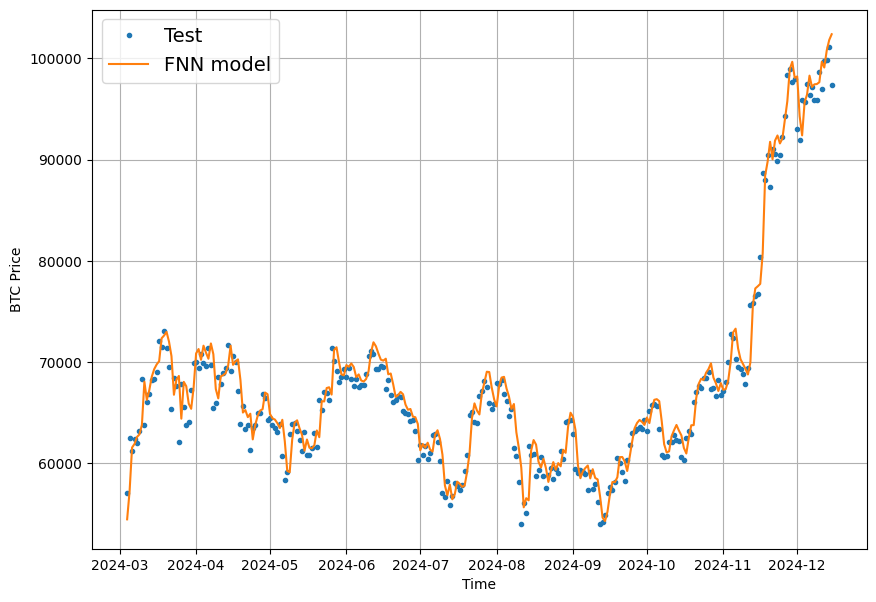

In [110]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 format=".",
                 label="Test")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(fnn_preds,axis=1),
                 format="-",
                 label="FNN model")

### Predict next month prices

In [129]:
fnn_full_model = tf.keras.models.clone_model(fnn_model)
fnn_full_model.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam())
history = fnn_full_model.fit(x=full_windows, 
                   y=full_labels,
                   epochs= 180,
                   verbose=0,
                   batch_size=32)

In [142]:
future_predictions = []
last_window = full_windows[-1]
for _ in range(30 // 7):  
    pred = make_preds(fnn_full_model, last_window.reshape(1, -1))
    future_predictions.extend(pred)
    last_window = np.append(last_window[7:], pred)
future_dates = pd.date_range(start=bitcoin_price.index[-1], periods=28)
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=["Predicted_Price"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


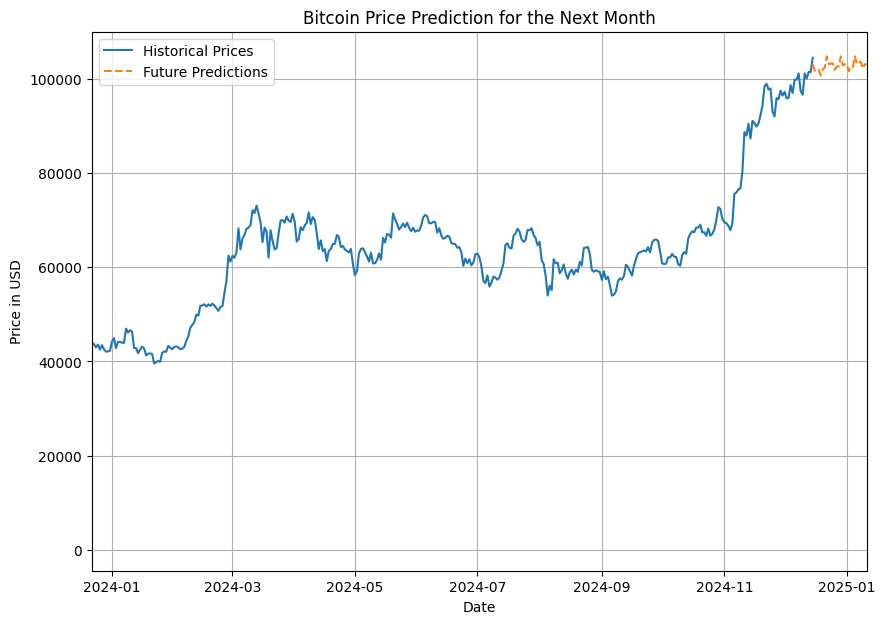

In [143]:
# Plot the future predictions
plt.figure(figsize=(10, 7))
plt.plot(bitcoin_price.index, bitcoin_price["Price"], label="Historical Prices")
plt.plot(future_predictions_df.index, future_predictions_df["Predicted_Price"], label="Future Predictions", linestyle="--")
plt.title("Bitcoin Price Prediction for the Next Month")
plt.xlabel("Date")
plt.ylabel("Price in USD")
plt.xlim(bitcoin_price.index[-360], future_predictions_df.index[-1])
plt.legend()
plt.grid()
plt.show()

## LSTM model

### Data preparation

In [181]:
full_windows, full_labels = make_windows(prices, window_size=7, horizon=1)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.1)

### Build a model

In [182]:
inputs = layers.Input(shape=(7,))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(1)(x)
lstm_model = tf.keras.Model(inputs=inputs, outputs=output, name="lstm_model")
lstm_model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam())
lstm_model.fit(x=train_windows,
                y=train_labels,
                epochs=200,
                verbose=0,
                batch_size=32,
                validation_data=(test_windows, test_labels),
                callbacks=[crteate_model_checkpoint(model_name=lstm_model.name)])

### Evaluate the model

In [189]:
# lstm_model = load_model("models/lstm_model.keras")
lstm_model.evaluate(test_windows, test_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1448.6584


1377.5880126953125

In [190]:
lstm_preds = make_preds(lstm_model, test_windows)
lstm_results = evaluate_preds(y_true=test_labels, y_pred=lstm_preds)
lstm_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


{'mae': np.float32(1377.5881),
 'mse': np.float32(3615433.8),
 'rmse': np.float32(1901.4294),
 'mape': np.float32(2.0267954),
 'mase': np.float32(7.65026)}

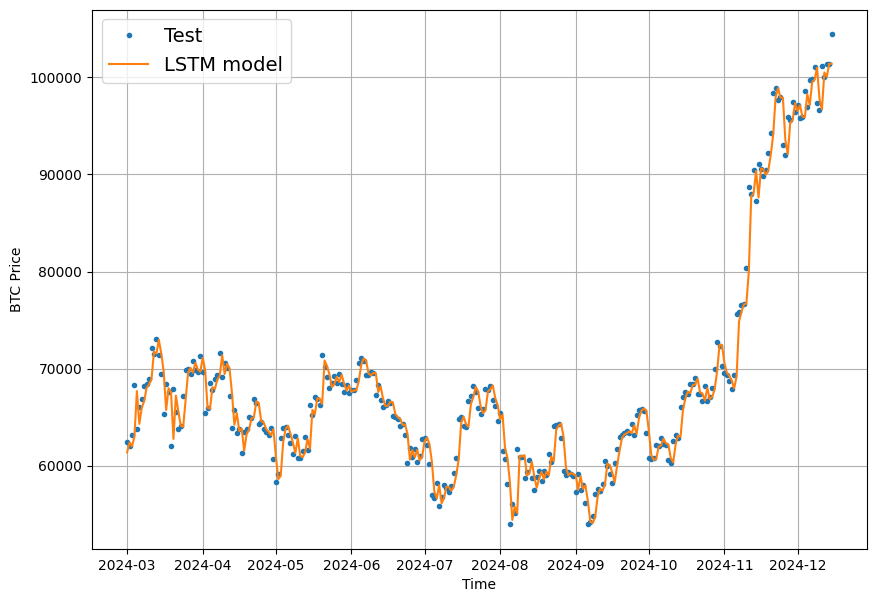

In [185]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 format=".",
                 label="Test")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=lstm_preds,
                 format="-",
                 label="LSTM model")

## Arima model

### Choose best p,d and q parameters for ARIMA model

A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>

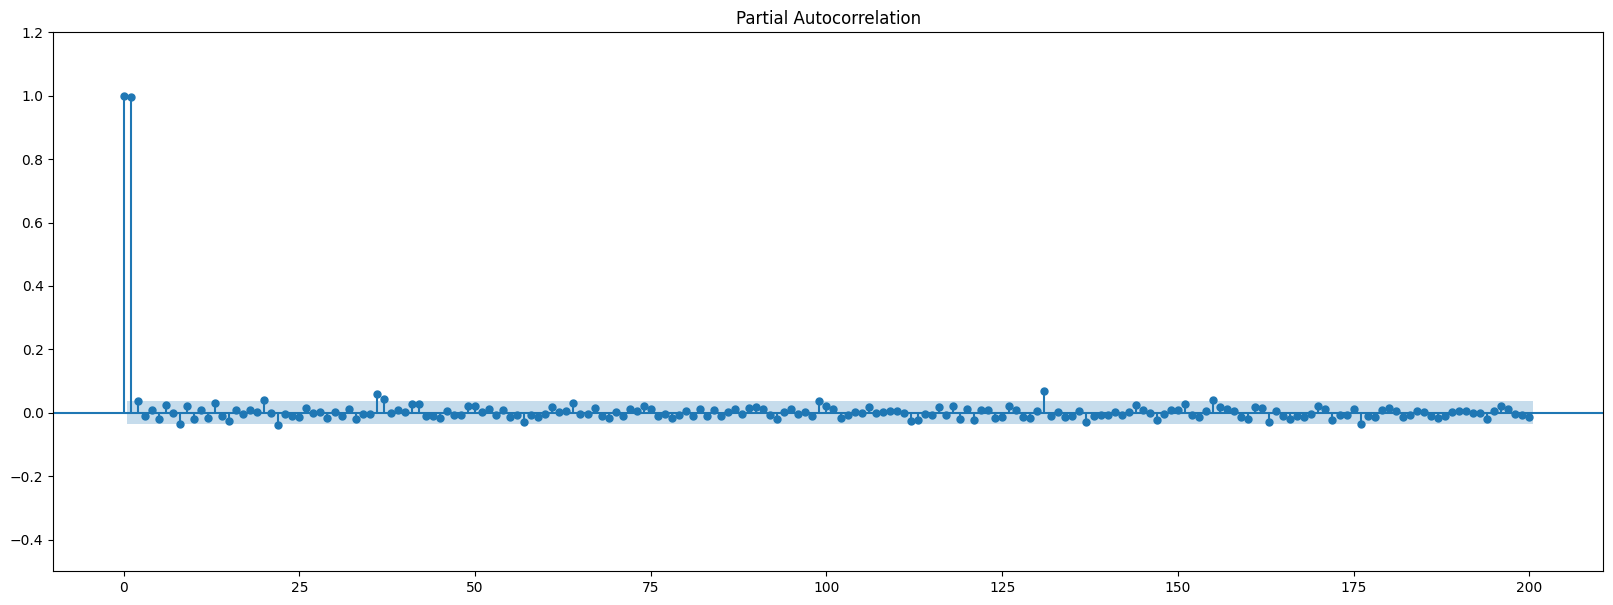

In [222]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20, 7)
plot_pacf(bitcoin_price["Price"], lags=200)
plt.ylim(-0.5, 1.2)
plt.show()

### Moving Average(q order)

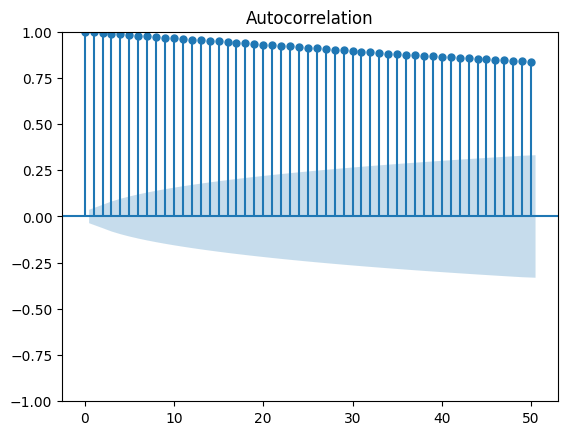

In [205]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bitcoin_price["Price"], lags=50);

This tells that the AR component should be more important than MA.\
<em>If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we    say that the stationarized series displays an "AR signature," meaning that the autocorrelation pattern can be explained more    easily by adding AR terms than by adding MA terms.</em><br>

### INTEGRATION(d order)

### Stationarity tests

#### Augmented Dickey-Fuller Test (ADF)

In [224]:
adf_test(bitcoin_price["Price"], title="Bitcoin Price")

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         0.278228
p-value                    0.976323
# lags used               28.000000
# observations          2877.000000
critical value (1%)       -3.432625
critical value (5%)       -2.862545
critical value (10%)      -2.567305
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


#### Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS)

In [225]:
import warnings
warnings.filterwarnings("ignore")
kpss_test(bitcoin_price["Price"], title="Bitcoin Price")

Kwiatkowski-Phillips-Schmidt-Shin Test: Bitcoin Price
KPSS test statistic       5.859885
p-value                   0.010000
# lags used              31.000000
critical value (10%)      0.347000
critical value (5%)       0.463000
critical value (2.5%)     0.574000
critical value (1%)       0.739000
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has a unit root and is non-stationary


Data is not-stationary, so it is necessary to differentiate the Bitcoin price.

In [226]:
btc_price_1d = bitcoin_price.diff().dropna()

In [227]:
adf_test(btc_price_1d["Price"], title="Bitcoin Price")

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic     -8.372082e+00
p-value                 2.645597e-13
# lags used             2.800000e+01
# observations          2.876000e+03
critical value (1%)    -3.432626e+00
critical value (5%)    -2.862545e+00
critical value (10%)   -2.567305e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [228]:
kpss_test(btc_price_1d["Price"], title="Bitcoin Price")

Kwiatkowski-Phillips-Schmidt-Shin Test: Bitcoin Price
KPSS test statistic       0.339684
p-value                   0.100000
# lags used              10.000000
critical value (10%)      0.347000
critical value (5%)       0.463000
critical value (2.5%)     0.574000
critical value (1%)       0.739000
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has no unit root and is stationary


Both tests showed that the data is stationary after 1 differencing, so the best d order for ARIMA model is `d = 1`

### Build and fit model

In [229]:
to_row = int(len(bitcoin_price) * 0.8)
training_data = list(bitcoin_price[0:to_row]["Price"])
testing_data = list(bitcoin_price[to_row:]["Price"])

In [230]:
model_predictions = []
n_test_observations = len(testing_data)

In [233]:
from statsmodels.tsa.arima.model import ARIMA
for i in range(n_test_observations):
    model = ARIMA(training_data, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

In [235]:
arima_results = evaluate_preds(y_true=testing_data, y_pred=model_predictions)
arima_results

{'mae': np.float32(949.5752),
 'mse': np.float32(2158218.5),
 'rmse': np.float32(1469.0876),
 'mape': np.float32(1.7358688),
 'mase': np.float32(0.9935978)}

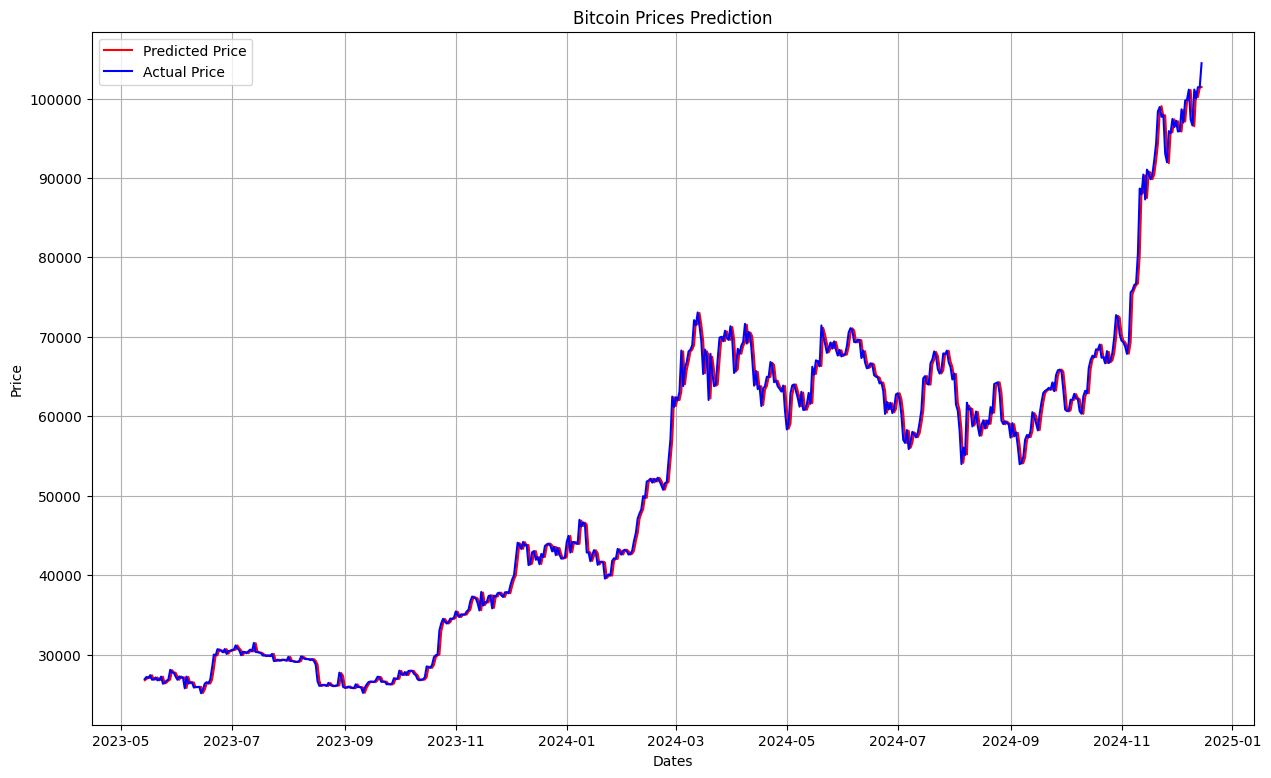

In [236]:
plt.figure(figsize=(15, 9))
plt.grid(True)

data_range = bitcoin_price[to_row:].index
model_predictions = model_predictions[:len(testing_data)]

plt.plot(data_range, model_predictions, color="red", label="Predicted Price")
plt.plot(data_range, testing_data, color="blue", label="Actual Price")
plt.title("Bitcoin Prices Prediction")
plt.xlabel("Dates")
plt.ylabel("Price")
plt.legend()

## CNN model

### Data preparation

In [251]:
full_windows, full_labels = make_windows(prices, window_size=10, horizon=1)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels,test_split=0.1)

### Build and fit model

In [253]:
cnn_model = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=7, strides=1, padding="causal", activation="relu"),
    layers.Dense(1)
], name="cnn_model")

cnn_model.compile(loss="mae",
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

cnn_model.fit(x=train_windows,
               y=train_labels,
               epochs=200,
               verbose=0,
               batch_size=32,
               validation_data=(test_windows, test_labels),
               callbacks=[crteate_model_checkpoint(model_name=cnn_model.name)])

In [254]:
cnn_preds = make_preds(cnn_model, test_windows)
cnn_results = evaluate_preds(y_true=test_labels, y_pred=cnn_preds)
cnn_results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


{'mae': np.float32(1386.4683),
 'mse': np.float32(3633649.8),
 'rmse': np.float32(1906.2135),
 'mape': np.float32(2.0418556),
 'mase': np.float32(7.655732)}

## N-BEATS Algorithm

### N-Beats layer

In [255]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 **kwargs): 
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

    def call(self,inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

### Data preparation

In [258]:
bitcoin_price_nbeats = bitcoin_price.copy()
for i in range(7):
    bitcoin_price_nbeats[f"Price+{i+1}"] = bitcoin_price_nbeats["Price"].shift(periods=i+1)

X = bitcoin_price_nbeats.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_price_nbeats.dropna()["Price"].astype(np.float32)

split_size = int(0.8 * len(X))
X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]

In [259]:
# Time to make dataset performant with tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features and labels by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch for performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Setting up N-BEATS algorithm hyperparameters

In [261]:
HORIZON = 1
WINDOW_SIZE = 7
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30 
INPUT_SIZE = WINDOW_SIZE*HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

### Build and fit model

In [301]:
# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): 

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) 

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
nbeats_model = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast)

# 8. Compile with MAE loss and Adam optimizer
nbeats_model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
nbeats_model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 249: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [302]:
nbeats_preds = make_preds(nbeats_model, test_dataset)
nbeats_results = evaluate_preds(y_true=y_test, y_pred=nbeats_preds)
nbeats_results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


{'mae': np.float32(951.65344),
 'mse': np.float32(2157803.8),
 'rmse': np.float32(1468.9465),
 'mape': np.float32(1.7468439),
 'mase': np.float32(0.9930824)}

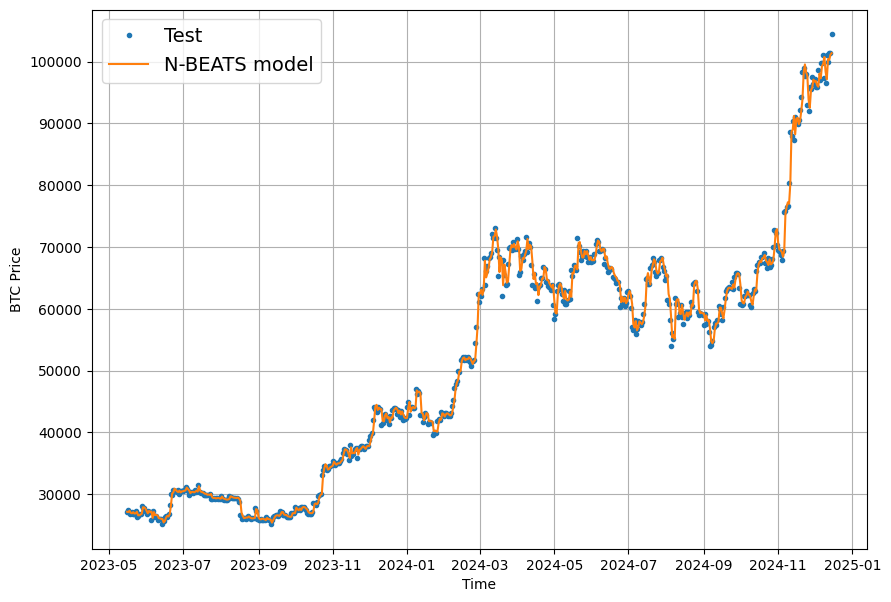

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test.index, values=y_test, format=".", label="Test")
plot_time_series(timesteps=X_test.index, values=nbeats_preds, format="-", label="N-BEATS model")